# Dataset Pruning Metrics

- References:
  - https://arxiv.org/pdf/2206.14486.pdf
  - https://dl.acm.org/doi/10.1145/2733381

In [1]:
import os
import pickle
import random
from tqdm.notebook import tqdm
from collections import Counter, defaultdict

import torch
import numpy as np
import pandas as pd

from transformers import (pipeline,
                          AutoTokenizer,
                          AutoModelForSequenceClassification,
                          Trainer, 
                          TrainingArguments,
                          EarlyStoppingCallback)

import evaluate
from transformers.pipelines.pt_utils import KeyDataset
from sentence_transformers import SentenceTransformer
from datasets import load_dataset, concatenate_datasets, load_from_disk, Dataset

# clustering
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans

# diversity
from textdiversity import (
    DocumentSemanticDiversity,
    AMRDiversity,
    POSSequenceDiversity,
    RhythmicDiversity,
    DependencyDiversity,
)
from apricot import FacilityLocationSelection

from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
torch.use_deterministic_algorithms(False)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

### Dataset

In [54]:
dataset = load_dataset("glue", "sst2", split="validation")
dataset = dataset.rename_column("sentence", "text")
original_text, original_labels = dataset['text'], dataset['label']

### Selectors

#### Random

In [8]:
class RandomSelector:
    def __init__(self, dataset):
        self.dataset = dataset
        
    def random_subset(self, size, seed=0):
        return self.dataset.shuffle(seed=seed).select(range(size))

#### Clustering

In [3]:
class ClusterSelector:
    def __init__(self, dataset, clusterer=None):
        self.dataset = dataset   
        self.dataset_len = len(self.dataset)
        self.num_classes = max(self.dataset['label']) + 1 
        self.clusterer = clusterer 
        self.save_dir = "./datasets/cluster_selector"

        # initialize return counters
        self.hard_samples_returned = 0
        self.easy_samples_returned = 0
        
    def fit(self):
        # initialize clustering pipeline
        min_samples = int(self.dataset_len / (self.num_classes * 10))
        self.embedder = SentenceTransformer("princeton-nlp/sup-simcse-roberta-large") # 'all-MiniLM-L6-v2'
        self.reducer = UMAP(n_components=50, metric='cosine') 
        self.clusterer =  HDBSCAN(min_cluster_size=self.num_classes, 
                                min_samples=min_samples)
        # fit cluster
        print("Extracting contextual embeddings from text...")
        self.embeddings = self.embedder.encode(self.dataset['text'], show_progress_bar=True)
        print("Reducing embedding dimensionality...")
        self.reduced_embeddings = self.reducer.fit_transform(self.embeddings)
        print("Clustering reduced embeddings...")
        self.clusterer.fit(self.reduced_embeddings)
        
        del self.embedder, self.reducer
        
        # cluster properties
        self.persistences = self.clusterer.cluster_persistence_
        self.cluster_weights = self.persistences / self.persistences.sum()

        # input properties
        self.outlier_scores = self.clusterer.outlier_scores_
        self.assignment_probs = self.clusterer.probabilities_
        self.clusters = self.clusterer.labels_

        self.add_column_to_dataset("outlier_score", self.outlier_scores)
        self.add_column_to_dataset("cluster_id", self.clusters)
        self.add_column_to_dataset("assignment_prob", self.assignment_probs)

        # clean dataset
        self.remove_noise()

    def filter_dataset(self, idxs, inplace=True):
        # remove from dataset
        filtered_dataset = self.dataset.filter(lambda ex, idx: idx not in idxs, with_indices=True)
        if inplace:
            self.dataset = filtered_dataset
            self.dataset_len = len(self.dataset)
            self.num_classes = max(self.dataset['label']) + 1 
            # remove from cluster info to maintain 1:1 mapping
            self.outlier_scores = np.delete(self.outlier_scores, idxs)
            self.assignment_probs = np.delete(self.assignment_probs, idxs)
            self.clusters = np.delete(self.clusters, idxs)
        else:
            return filtered_dataset

    def add_column_to_dataset(self, column_name, data):
        self.dataset = self.dataset.add_column(column_name, data)

    def remove_noise(self):
        noisy_idxs = np.where(self.clusters == -1)[0]
        self.filter_dataset(noisy_idxs)

    def return_hard_sample(self):
        self.hard_samples_returned += 1
        return self.dataset.sort("outlier_score", reverse=True)[self.hard_samples_returned]

    def return_easy_sample(self):
        self.hard_samples_returned += 1
        return self.dataset.sort("outlier_score", reverse=False)[self.hard_samples_returned]

    def hard_subset(self, size):
        return self.dataset.sort("outlier_score", reverse=True).select(range(size))

    def easy_subset(self, size):
        return self.dataset.sort("outlier_score", reverse=False).select(range(size))
    
    def save_dataset(self):
        os.makedirs(self.save_dir, exist_ok = True)
        self.dataset.save_to_disk(self.save_dir)
        
    def load_dataset(self, ):
        self.dataset = load_from_disk(self.save_dir)

    def balanced_subset(self, size):
        num_per_class = int(size / self.num_classes)
        class_datasets, selected_idxs = [], []
        for cls in range(num_classes):
            class_dataset = selector.dataset.filter(lambda ex: ex["label"] == cls)
            idxs = random.sample(range(len(class_dataset)), num_per_class)
            class_datasets.append(class_dataset.select(idxs))
            selected_idxs.extend(idxs)
        balanced_dataset = concatenate_datasets(class_datasets)
        balanced_dataset_len = len(balanced_dataset)
        if balanced_dataset_len != size:
            num_to_select = size - balanced_dataset_len
            idxs = random.sample(range(num_to_select), num_to_select)
            filtered_dataset = self.filter_dataset(selected_idxs, inplace=False)
            balanced_dataset = concatenate_datasets(
                [balanced_dataset, 
                 filtered_dataset.select(idxs)])
        return balanced_dataset

#### Diversity

In [12]:
class DiversitySelector:
    def __init__(self, dataset, rankings=None, diversity_weights=None):
        self.dataset = dataset   
        self.dataset_len = len(self.dataset)
        self.num_classes = max(self.dataset['label']) + 1 
        self.rankings = rankings
        self.save_dir = "./datasets/diversity_selector"
        self.diversities = [
            DocumentSemanticDiversity,
            POSSequenceDiversity,
            RhythmicDiversity,
            DependencyDiversity
        ]  
        self.diversity_weights = diversity_weights

        # initialize return counters
        self.hard_samples_returned = 0
        self.easy_samples_returned = 0
        
    def fit(self):
        self.calculate_similarities()
        self.calculate_rankings()
        
    def calculate_similarities(self):
        similarities = []
        for div in tqdm(self.diversities):
            featurizer = div()
            features, corpus = featurizer.extract_features(dataset['text'])
            Z = featurizer.calculate_similarities(features)
            similarities.append(Z)
            del featurizer
        self.similarities = similarities
        
    def calculate_rankings(self):
        
        gains, rankings = [], []
        for d, Z in zip(self.diversities, self.similarities):
            selector = FacilityLocationSelection(
                n_samples=self.dataset_len, 
                metric='euclidean', 
                optimizer='lazy')
            selector = selector.fit(Z)
            gains.append(selector.gains)
            rankings.append(selector.ranking)
            self.add_column_to_dataset(d.__name__+"_rank", selector.ranking)
            
        self.dataset = self.dataset.map(self.calculate_avg_rank)
            
        self.gains = gains
        self.rankings = rankings
        
    def recompute_avg_rank(self, diversity_weights=None):
        if diversity_weights is not None:
            self.diversity_weights = diversity_weights
        self.dataset = self.dataset.map(self.calculate_avg_rank)

    def filter_dataset(self, idxs, inplace=True):
        # remove from dataset
        filtered_dataset = self.dataset.filter(lambda ex, idx: idx not in idxs, with_indices=True)
        if inplace:
            self.dataset = filtered_dataset
            self.dataset_len = len(self.dataset)
            self.num_classes = max(self.dataset['label']) + 1 
            # remove from cluster info to maintain 1:1 mapping
            self.outlier_scores = np.delete(self.outlier_scores, idxs)
            self.assignment_probs = np.delete(self.assignment_probs, idxs)
            self.clusters = np.delete(self.clusters, idxs)
        else:
            return filtered_dataset

    def add_column_to_dataset(self, column_name, data):
        self.dataset = self.dataset.add_column(column_name, data)

    def remove_noise(self):
        noisy_idxs = np.where(self.clusters == -1)[0]
        self.filter_dataset(noisy_idxs)

    def return_hard_sample(self):
        self.hard_samples_returned += 1
        return self.dataset.sort("rank", reverse=True)[self.hard_samples_returned]

    def return_easy_sample(self):
        self.hard_samples_returned += 1
        return self.dataset.sort("rank", reverse=False)[self.hard_samples_returned]

    def hard_subset(self, size):
        return self.dataset.sort("rank", reverse=True).select(range(size))

    def easy_subset(self, size):
        return self.dataset.sort("rank", reverse=False).select(range(size))
    
    def save_dataset(self):
        os.makedirs(self.save_dir, exist_ok = True)
        self.dataset.save_to_disk(self.save_dir)
        
    def load_dataset(self):
        self.dataset = load_from_disk(self.save_dir)

    def balanced_subset(self, size):
        num_per_class = int(size / self.num_classes)
        class_datasets, selected_idxs = [], []
        for cls in range(num_classes):
            class_dataset = selector.dataset.filter(lambda ex: ex["label"] == cls)
            idxs = random.sample(range(len(class_dataset)), num_per_class)
            class_datasets.append(class_dataset.select(idxs))
            selected_idxs.extend(idxs)
        balanced_dataset = concatenate_datasets(class_datasets)
        balanced_dataset_len = len(balanced_dataset)
        if balanced_dataset_len != size:
            num_to_select = size - balanced_dataset_len
            idxs = random.sample(range(num_to_select), num_to_select)
            filtered_dataset = self.filter_dataset(selected_idxs, inplace=False)
            balanced_dataset = concatenate_datasets(
                [balanced_dataset, 
                 filtered_dataset.select(idxs)])
        return balanced_dataset

    def calculate_avg_rank(self, example):
        sem = example["DocumentSemanticDiversity_rank"]
        mor = example["POSSequenceDiversity_rank"]
        pho = example["RhythmicDiversity_rank"]
        syn = example["DependencyDiversity_rank"]
        ranks = [sem, mor, pho, syn]
        avg_rank = np.average(ranks, weights=self.diversity_weights)
        example["rank"] = avg_rank
        return example

### Model

In [6]:
pipe = pipeline(task="sentiment-analysis", device=0)

In [5]:
def training_pipeline(datasets, selector, difficulty="hard", num_samples=100, seed=0):
    
    # setup
    MODEL_NAME = "bert-base-uncased"
    num_labels = max(datasets["train"]['label']) + 1 
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    metric = evaluate.load("accuracy")
    
    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True)

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return metric.compute(predictions=predictions, references=labels)
    
    # dataset selection
    if not hasattr(selector, "dataset"):
        selector = selector(datasets["train"])
    
    if difficulty == "hard":
        train_dataset = selector.hard_subset(num_samples)
    elif difficulty == "easy":
        train_dataset = selector.easy_subset(num_samples)
    elif difficulty == "random":
        train_dataset = selector.random_subset(num_samples, seed=seed)
        
    eval_dataset  = datasets["validation"].shuffle(seed=seed)
    
    if -1 in datasets["test"]["label"]:
        split_dataset = eval_dataset.train_test_split(test_size=0.5)
        eval_dataset  = split_dataset["train"]
        test_dataset  = split_dataset["test"]
    else:
        test_dataset  = datasets["test"]
    
    tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
    tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)
    tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)
        
    # training
    checkpoint = MODEL_NAME + "_" + selector.__class__.__name__ + "_" + difficulty
    
    callbacks = []
    escb = EarlyStoppingCallback(
        early_stopping_patience=3
    )
    callbacks.append(escb)    
    
    train_batch_size = 4
    eval_batch_size = 4
    num_epoch = 10
    gradient_accumulation_steps = 1
    max_steps = int((len(train_dataset) * num_epoch / gradient_accumulation_steps) / train_batch_size)
    logging_steps = max_steps // num_epoch

    training_args = TrainingArguments(
        output_dir=checkpoint,
        overwrite_output_dir=True,
        max_steps=max_steps,
        save_steps=logging_steps,
        save_total_limit=1,
        per_device_train_batch_size=train_batch_size,
        per_device_eval_batch_size=eval_batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps, 
        warmup_steps=int(max_steps / 10),
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=logging_steps,
        logging_first_step=True,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        evaluation_strategy="steps")

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_eval_dataset,
        compute_metrics=compute_metrics,
        callbacks=callbacks
    )
    
    trainer.train()
    
    trainer.eval_dataset = tokenized_test_dataset
    
    out = trainer.evaluate()
    
    return out

### Analysis | Testing

In [6]:
def extract_probs(results):
    return np.array([[1-r['score'], r['score']] if r['label'] == "POSITIVE" else [r['score'], 1-r['score']] for r in results])

def accuracy_pipeline(pipe, dataset):
    preds = extract_probs(pipe(KeyDataset(dataset, "text")))
    acc = accuracy_score(np.argmax(preds, -1), dataset['label'])
    return acc

In [7]:
num_samples = 100

#### Random

In [11]:
idxs = random.sample(range(len(dataset)), num_samples)
rand_acc = accuracy_pipeline(pipe, dataset.select(idxs))

print(f"rand_acc: {rand_acc}")

rand_acc: 0.92


#### Clustering

In [59]:
embedder   = SentenceTransformer("princeton-nlp/sup-simcse-roberta-large") # 'all-MiniLM-L6-v2'
embeddings = embedder.encode(original_text, show_progress_bar=True)

umap_fn         = UMAP(n_components=50, metric='cosine', verbose=True)
umap_embeddings = umap_fn.fit_transform(embeddings)

num_classes = 2
min_samples = int(len(dataset) / (num_classes * 10))
clusterer = HDBSCAN(min_cluster_size=2, min_samples=min_samples)
clusterer.fit(umap_embeddings)

loading configuration file C:\Users\Fabrice/.cache\torch\sentence_transformers\princeton-nlp_sup-simcse-roberta-large\config.json
Model config RobertaConfig {
  "_name_or_path": "C:\\Users\\Fabrice/.cache\\torch\\sentence_transformers\\princeton-nlp_sup-simcse-roberta-large",
  "architectures": [
    "RobertaModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file C:\Users\Fabrice/.cache\torch\sentence_transformers\princeton-nl

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

UMAP(angular_rp_forest=True, metric='cosine', n_components=50, verbose=True)
Tue Oct 25 19:45:34 2022 Construct fuzzy simplicial set
Tue Oct 25 19:45:35 2022 Finding Nearest Neighbors
Tue Oct 25 19:45:35 2022 Finished Nearest Neighbor Search
Tue Oct 25 19:45:35 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Oct 25 19:45:38 2022 Finished embedding


HDBSCAN(min_cluster_size=2, min_samples=43)

In [60]:
cluster_selector = ClusterSelector(dataset, clusterer)
cluster_selector.fit()

hard_acc = accuracy_pipeline(pipe, cluster_selector.hard_subset(num_samples))
easy_acc = accuracy_pipeline(pipe, cluster_selector.easy_subset(num_samples))

print(f"hard_acc: {hard_acc}")
print(f"easy_acc: {easy_acc}")

  0%|          | 0/1 [00:00<?, ?ba/s]

hard_acc: 0.99
easy_acc: 0.95


#### Diversity

In [15]:
diversities = [
    DocumentSemanticDiversity,
    POSSequenceDiversity,
    RhythmicDiversity,
    DependencyDiversity
]

similarities = []
for div in tqdm(diversities):
    featurizer = div()
    features, corpus = featurizer.extract_features(dataset['text'])
    Z = featurizer.calculate_similarities(features)
    similarities.append(Z)
    del featurizer
    
gains, rankings = [], []
for Z in similarities:
    selector = FacilityLocationSelection(n_samples=len(dataset), metric='euclidean', optimizer='lazy')
    selector = selector.fit(Z)
    gains.append(selector.gains)
    rankings.append(selector.ranking)
    
rankings = average_rankings(rankings)

  0%|          | 0/4 [00:00<?, ?it/s]

In [17]:
diversity_selector = DiversitySelector(dataset, rankings)
diversity_selector.fit()

hard_acc = accuracy_pipeline(pipe, diversity_selector.hard_subset(num_samples))
easy_acc = accuracy_pipeline(pipe, diversity_selector.easy_subset(num_samples))

print(f"hard_acc: {hard_acc}")
print(f"easy_acc: {easy_acc}")

hard_acc: 0.9
easy_acc: 0.89


### Analysis | Training

In [6]:
datasets = load_dataset("glue", "sst2")
datasets = datasets.rename_column("sentence", "text")

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
def calculate_weight_distribution(semantic_weight=0.25):
    return [semantic_weight] + [(1-semantic_weight)/3] * 3

In [74]:
# building selectors once =================================================

num_samples = 10000
num_classes = 2

## random_selector ========================================================

dataset = datasets["train"]

random_selector = RandomSelector(dataset)

## cluster_selector =======================================================

dataset = datasets["train"]# .select(range(num_samples))

cluster_selector = ClusterSelector(dataset)

if not os.path.exists(cluster_selector.save_dir):
    print("computing cluster_selector dataset...")
    cluster_selector.fit()
    cluster_selector.save_dataset()
else:
    print("loading precomputed cluster_selector dataset...")
    cluster_selector.load_dataset()
    
## diversity_selector =====================================================

dataset = datasets["train"].select(range(num_samples)) # can't process as much data

diversity_weights = calculate_weight_distribution(0.9)
diversity_selector = DiversitySelector(dataset, diversity_weights=diversity_weights)    

if not os.path.exists(diversity_selector.save_dir):
    print("computing diversity_selector dataset...")
    diversity_selector.fit()
    diversity_selector.save_dataset()
else:
    print("loading precomputed diversity_selector dataset...")
    diversity_selector.load_dataset()
    diversity_selector.recompute_avg_rank(diversity_weights)

loading precomputed cluster_selector dataset...
loading precomputed diversity_selector dataset...


  0%|          | 0/10000 [00:00<?, ?ex/s]

#### Searching for good diversity weights

In [39]:
num_trials = 3
num_samples = 100
selectors = [diversity_selector]
difficulties = ["easy", "hard"]
weights = [calculate_distribution(w) for w in np.linspace(0, 1, 11)]

results = []
for n in range(num_trials):
    for d in difficulties:
        for s in selectors:
            for w in weights:
                s.recompute_avg_rank(w)
                out = training_pipeline(datasets, 
                                        selector=s, 
                                        difficulty=d, 
                                        num_samples=num_samples,
                                        seed=n)
                out['selector'] = s.__class__.__name__
                out['difficulty'] = d
                out['num_samples'] = num_samples
                out['trial'] = n
                out["diversity_weights"] = w

                results.append(out)

  0%|          | 0/10000 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 250


{'loss': 0.7276, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.04}


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4


{'loss': 0.6786, 'learning_rate': 5e-05, 'epoch': 1.0}


Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json


{'eval_loss': 0.6505416631698608, 'eval_accuracy': 0.5779816513761468, 'eval_runtime': 13.3647, 'eval_samples_per_second': 32.623, 'eval_steps_per_second': 8.156, 'epoch': 1.0}


Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-125] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-200] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4


{'loss': 0.4315, 'learning_rate': 4.4444444444444447e-05, 'epoch': 2.0}


Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-50
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-50\config.json


{'eval_loss': 0.717947781085968, 'eval_accuracy': 0.6605504587155964, 'eval_runtime': 13.59, 'eval_samples_per_second': 32.083, 'eval_steps_per_second': 8.021, 'epoch': 2.0}


Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-50\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-25] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4


{'loss': 0.1587, 'learning_rate': 3.888888888888889e-05, 'epoch': 3.0}


Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-75
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-75\config.json


{'eval_loss': 0.7779666781425476, 'eval_accuracy': 0.8279816513761468, 'eval_runtime': 13.7392, 'eval_samples_per_second': 31.734, 'eval_steps_per_second': 7.934, 'epoch': 3.0}


Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-75\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-50] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4


{'loss': 0.0625, 'learning_rate': 3.3333333333333335e-05, 'epoch': 4.0}


Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-100
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-100\config.json


{'eval_loss': 0.7760211229324341, 'eval_accuracy': 0.8256880733944955, 'eval_runtime': 13.812, 'eval_samples_per_second': 31.567, 'eval_steps_per_second': 7.892, 'epoch': 4.0}


Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-100\pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4


{'loss': 0.0012, 'learning_rate': 2.777777777777778e-05, 'epoch': 5.0}


Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-125
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-125\config.json


{'eval_loss': 0.9705702662467957, 'eval_accuracy': 0.8188073394495413, 'eval_runtime': 13.9019, 'eval_samples_per_second': 31.363, 'eval_steps_per_second': 7.841, 'epoch': 5.0}


Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-125\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-100] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4


{'loss': 0.0007, 'learning_rate': 2.2222222222222223e-05, 'epoch': 6.0}


Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-150
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-150\config.json


{'eval_loss': 1.0256743431091309, 'eval_accuracy': 0.823394495412844, 'eval_runtime': 14.0004, 'eval_samples_per_second': 31.142, 'eval_steps_per_second': 7.785, 'epoch': 6.0}


Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-150\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-125] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from bert-base-uncased_DiversitySelector_easy\checkpoint-75 (score: 0.8279816513761468).
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4


{'train_runtime': 164.2074, 'train_samples_per_second': 6.09, 'train_steps_per_second': 1.522, 'train_loss': 0.22251481232543788, 'epoch': 6.0}
{'eval_loss': 0.7854753136634827, 'eval_accuracy': 0.8211009174311926, 'eval_runtime': 14.0894, 'eval_samples_per_second': 30.945, 'eval_steps_per_second': 7.736, 'epoch': 6.0}


  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.686700,0.665892,0.672018
50,0.536200,0.572208,0.740826
75,0.195300,0.733247,0.727064
100,0.114900,1.669054,0.681193
125,0.002000,1.535561,0.722477


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-75] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-150] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.708900,0.698894,0.511468
50,0.463600,0.583903,0.688073
75,0.145300,0.877457,0.736239
100,0.040700,1.165362,0.750000
125,0.000900,1.264704,0.761468
150,0.000500,1.320194,0.754587
175,0.000400,1.351123,0.756881
200,0.000400,1.368937,0.756881


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-50] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-125] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.673400,0.677687,0.559633
50,0.466100,0.612466,0.697248
75,0.113100,0.743298,0.786697
100,0.003200,1.094273,0.782110
125,0.001000,1.152779,0.784404
150,0.000700,1.186120,0.784404


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-125] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-200] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.697600,0.745792,0.497706
50,0.589800,0.637605,0.637615
75,0.358300,0.689344,0.708716
100,0.082600,1.308691,0.724771
125,0.015600,1.138161,0.782110
150,0.001000,1.251711,0.779817
175,0.000700,1.300948,0.779817
200,0.000600,1.306580,0.782110


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-75] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-150] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.687300,0.704472,0.497706
50,0.439000,0.593538,0.720183
75,0.053200,0.997100,0.800459
100,0.057400,1.246818,0.791284
125,0.000800,1.261506,0.795872
150,0.000600,1.313519,0.802752
175,0.000500,1.343296,0.800459
200,0.000500,1.348887,0.802752
225,0.000400,1.356055,0.802752


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-125] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-200] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.678800,0.707113,0.513761
50,0.354500,0.571581,0.756881
75,0.171200,1.100400,0.770642
100,0.002100,1.074505,0.802752
125,0.000900,1.180178,0.816514
150,0.000500,1.234486,0.811927
175,0.000500,1.261803,0.811927
200,0.000400,1.281639,0.811927


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-150] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-225] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.703600,0.647052,0.651376
50,0.420500,0.546329,0.736239
75,0.032900,1.014939,0.798165
100,0.001600,1.529453,0.763761
125,0.000700,1.583083,0.768349
150,0.000600,1.592174,0.772936


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-125] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-200] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.687600,0.746119,0.506881
50,0.598200,0.728200,0.619266
75,0.215700,0.633867,0.782110
100,0.011600,1.062502,0.775229
125,0.001400,1.221415,0.770642
150,0.000800,1.182185,0.793578
175,0.000700,1.205439,0.791284
200,0.000600,1.223922,0.795872
225,0.000600,1.219697,0.800459
250,0.000500,1.223661,0.800459


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-75] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-150] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.692700,0.703250,0.506881
50,0.452500,0.624467,0.676606
75,0.068000,0.876784,0.763761
100,0.001900,1.715451,0.720183
125,0.000600,1.844209,0.715596
150,0.000400,1.827245,0.722477


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-225] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-250] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.714300,0.656911,0.598624
50,0.511300,0.594473,0.681193
75,0.208500,0.417824,0.857798
100,0.059800,0.685117,0.834862
125,0.026100,0.944119,0.827982
150,0.000700,1.507626,0.761468


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-75] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-150] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.692100,0.656973,0.699541
50,0.469000,0.504390,0.747706
75,0.130900,0.700271,0.823394
100,0.056700,0.813871,0.846330
125,0.000900,0.948726,0.839450
150,0.000600,1.058214,0.811927
175,0.000500,1.076073,0.814220


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-150] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-225] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.751600,0.688799,0.504587
50,0.610500,0.549769,0.740826
75,0.173200,0.559602,0.857798
100,0.098900,0.811807,0.839450
125,0.001300,2.012208,0.672018
150,0.042000,0.906684,0.844037


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-100] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-175] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.676800,0.684782,0.502294
50,0.538200,0.646012,0.626147
75,0.238300,0.614892,0.782110
100,0.044500,0.898545,0.825688
125,0.050600,0.932840,0.832569
150,0.000800,0.992320,0.834862
175,0.000600,1.023345,0.837156
200,0.000500,1.041545,0.834862
225,0.000400,1.053233,0.837156
250,0.000400,1.057318,0.837156


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-75] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-150] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.715600,0.662302,0.520642
50,0.447000,0.425107,0.814220
75,0.097700,0.627926,0.844037
100,0.178700,0.819118,0.850917
125,0.001300,0.928770,0.844037
150,0.000700,0.918251,0.848624
175,0.000600,0.938954,0.850917


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-175] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-250] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.719900,0.684030,0.534404
50,0.590100,0.435784,0.823394
75,0.132600,0.890116,0.791284
100,0.088600,1.684669,0.697248
125,0.069000,0.735171,0.841743
150,0.000900,0.830720,0.839450
175,0.000500,0.793777,0.855505
200,0.000400,0.819070,0.853211
225,0.000400,0.833785,0.853211
250,0.000400,0.838329,0.853211


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-100] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-175] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.698000,0.657593,0.506881
50,0.518000,0.481127,0.798165
75,0.218400,0.511530,0.846330
100,0.009400,1.431318,0.731651
125,0.060400,1.037269,0.807339
150,0.001200,0.945073,0.834862


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-175] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-250] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.712300,0.644000,0.731651
50,0.501300,0.563325,0.715596
75,0.212400,0.643084,0.844037
100,0.060200,0.724210,0.869266
125,0.001100,0.906430,0.841743
150,0.000500,0.875451,0.857798
175,0.000400,0.851282,0.866972


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-75] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-150] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.712900,0.694508,0.504587
50,0.391600,0.403196,0.841743
75,0.246500,0.656226,0.830275
100,0.004400,0.842008,0.818807
125,0.001600,0.862622,0.816514


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-100] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-175] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.680100,0.696259,0.502294
50,0.623800,0.540961,0.761468
75,0.211600,0.535173,0.848624
100,0.070100,0.814344,0.853211
125,0.071400,0.935714,0.839450
150,0.000400,0.774485,0.862385
175,0.000400,0.799765,0.860092
200,0.000300,0.807671,0.860092
225,0.000300,0.811396,0.860092


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-50] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-125] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.704500,0.711716,0.511468
50,0.481700,0.501079,0.761468
75,0.233500,1.189082,0.644495
100,0.095400,0.796297,0.814220
125,0.001500,0.606061,0.860092
150,0.000900,0.649525,0.871560
175,0.000600,0.671240,0.876147
200,0.000500,0.684287,0.876147
225,0.000400,0.690871,0.871560
250,0.000400,0.693327,0.871560


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-150] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-225] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.701800,0.731784,0.502294
50,0.614200,0.799321,0.502294
75,0.330500,0.647842,0.750000
100,0.171000,0.964807,0.818807
125,0.003300,1.272660,0.784404
150,0.000500,1.705701,0.738532
175,0.000400,1.495045,0.763761


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-175] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-250] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.686300,0.692797,0.497706
50,0.567300,0.428632,0.805046
75,0.187000,0.556286,0.830275
100,0.008500,0.866923,0.798165
125,0.002500,1.064680,0.775229
150,0.009800,0.898120,0.823394


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-75] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-150] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.686700,0.668052,0.660550
50,0.536200,0.620523,0.722477
75,0.195300,0.731786,0.724771
100,0.114900,1.883362,0.651376
125,0.002000,1.766845,0.688073
150,0.001000,2.136322,0.665138


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-75] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-150] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.693000,0.685731,0.532110
50,0.490400,0.610377,0.644495
75,0.156000,1.253318,0.651376
100,0.028700,2.074539,0.644495
125,0.001300,1.526871,0.727064
150,0.000700,1.605276,0.713303
175,0.000500,2.118135,0.669725
200,0.000400,2.162755,0.667431


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-75] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-150] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.673400,0.701276,0.495413
50,0.466100,0.574106,0.720183
75,0.113100,0.769520,0.788991
100,0.003200,1.137685,0.784404
125,0.001000,1.196336,0.786697
150,0.000700,1.234125,0.786697


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-125] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-200] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.697600,0.719161,0.538991
50,0.589800,0.633341,0.649083
75,0.358300,0.629144,0.736239
100,0.082600,1.219165,0.740826
125,0.015600,1.169269,0.777523
150,0.001000,1.261524,0.782110
175,0.000700,1.307891,0.782110
200,0.000600,1.320506,0.784404
225,0.000500,1.333739,0.784404
250,0.000500,1.338780,0.784404


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-75] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-150] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.691400,0.675603,0.552752
50,0.429100,0.731406,0.607798
75,0.082700,0.932635,0.763761
100,0.002200,2.051939,0.692661
125,0.000600,1.942358,0.731651
150,0.000400,1.852649,0.745413


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-200] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-250] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.688900,0.716981,0.541284
50,0.551800,0.912312,0.573394
75,0.158900,0.982953,0.688073
100,0.015000,1.664645,0.681193
125,0.006800,2.504064,0.626147
150,0.000800,2.520860,0.637615


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-75] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-150] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.708300,0.723372,0.543578
50,0.521500,0.682334,0.628440
75,0.212300,0.684152,0.759174
100,0.008800,0.902829,0.756881
125,0.001500,1.210796,0.756881
150,0.000800,1.248863,0.759174


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-75] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-150] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.687600,0.724672,0.541284
50,0.598200,0.772505,0.587156
75,0.215700,0.677797,0.763761
100,0.011600,1.064716,0.768349
125,0.001400,1.177679,0.782110
150,0.000800,1.181072,0.784404
175,0.000700,1.209314,0.782110
200,0.000600,1.226602,0.786697
225,0.000600,1.221170,0.791284
250,0.000500,1.225216,0.791284


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-75] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-150] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.692700,0.729699,0.465596
50,0.452500,0.612453,0.685780
75,0.068000,0.820182,0.770642
100,0.001900,1.611539,0.727064
125,0.000600,1.730986,0.729358
150,0.000400,1.707604,0.736239


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-225] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-250] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.714300,0.647988,0.639908
50,0.511300,0.556690,0.711009
75,0.208500,0.438615,0.848624
100,0.059800,0.659523,0.848624
125,0.026100,0.903092,0.823394
150,0.000700,1.318945,0.791284


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-75] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-150] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.692100,0.664259,0.667431
50,0.469000,0.503786,0.754587
75,0.130900,0.693293,0.821101
100,0.056700,0.759930,0.850917
125,0.000900,0.900806,0.848624
150,0.000600,1.072287,0.818807
175,0.000500,1.090815,0.821101


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-100] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-175] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.751600,0.708135,0.470183
50,0.610500,0.554304,0.740826
75,0.173200,0.575694,0.853211
100,0.098900,0.770360,0.848624
125,0.001300,2.021502,0.674312
150,0.042000,0.804614,0.864679
175,0.000500,0.831975,0.860092
200,0.000400,0.831431,0.864679
225,0.000400,0.837645,0.864679


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-100] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-175] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.719700,0.694052,0.458716
50,0.562600,0.592960,0.747706
75,0.237800,0.826650,0.802752
100,0.070100,0.841994,0.839450
125,0.030400,0.889344,0.834862
150,0.000600,0.954041,0.834862
175,0.000500,0.984558,0.839450


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-150] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-225] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.723500,0.730326,0.458716
50,0.617700,0.529139,0.795872
75,0.202000,0.707309,0.834862
100,0.044600,1.419124,0.752294
125,0.063600,0.896866,0.834862
150,0.000500,0.920655,0.837156
175,0.000500,0.944015,0.837156
200,0.000400,0.996425,0.832569
225,0.000300,1.004848,0.832569


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-100] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-175] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.692800,0.672887,0.559633
50,0.538500,0.525799,0.772936
75,0.158100,0.968873,0.788991
100,0.080000,2.424450,0.612385
125,0.068000,0.947514,0.839450
150,0.001400,0.744398,0.869266
175,0.000600,0.774455,0.862385
200,0.000500,0.790106,0.860092
225,0.000500,0.798198,0.862385


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-150] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-225] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.702900,0.706925,0.458716
50,0.565000,0.433761,0.837156
75,0.148800,1.019661,0.772936
100,0.094800,1.224751,0.811927
125,0.001000,1.102868,0.825688


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-150] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-225] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.692300,0.658478,0.573394
50,0.451100,0.456102,0.807339
75,0.059400,0.693398,0.846330
100,0.043800,0.930019,0.839450
125,0.009500,0.882330,0.848624
150,0.000400,0.935295,0.841743
175,0.000300,0.859767,0.855505
200,0.000300,0.861659,0.855505
225,0.000300,0.866589,0.855505
250,0.057500,0.869674,0.857798


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-50] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-125] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.696500,0.752496,0.463303
50,0.401500,0.424209,0.821101
75,0.096300,0.529508,0.876147
100,0.002000,1.003169,0.809633
125,0.000800,0.959433,0.823394
150,0.000600,0.955168,0.830275


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-250] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.707400,0.672647,0.534404
50,0.515700,0.487307,0.791284
75,0.079400,0.552428,0.850917
100,0.001400,0.931494,0.846330
125,0.000400,1.001818,0.839450
150,0.000300,1.024653,0.839450


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-75] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-150] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.689000,0.654052,0.600917
50,0.415700,0.420622,0.816514
75,0.121600,0.782334,0.788991
100,0.072300,0.949866,0.805046
125,0.001600,0.906183,0.825688
150,0.000700,0.980367,0.834862
175,0.000500,0.954729,0.827982
200,0.000500,0.850286,0.846330
225,0.000400,0.844791,0.844037
250,0.000400,0.846635,0.844037


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-75] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-150] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.701800,0.757019,0.458716
50,0.614200,0.847631,0.458716
75,0.330500,0.646546,0.763761
100,0.171000,0.870229,0.834862
125,0.003300,1.247519,0.791284
150,0.000500,1.761438,0.713303
175,0.000400,1.476703,0.768349


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-200] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-250] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.686300,0.680616,0.552752
50,0.567300,0.418934,0.814220
75,0.187000,0.556701,0.821101
100,0.008500,0.864970,0.791284
125,0.002500,1.054844,0.775229
150,0.009800,0.913589,0.818807


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-75] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-150] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.686700,0.670642,0.658257
50,0.536200,0.624615,0.704128
75,0.195300,0.769956,0.720183
100,0.114900,1.704788,0.678899
125,0.002000,1.678375,0.694954
150,0.001000,1.950401,0.692661


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-75] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-150] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.693000,0.682347,0.566514
50,0.490400,0.620196,0.658257
75,0.156000,1.371475,0.628440
100,0.028700,2.450023,0.584862
125,0.001300,1.578028,0.713303
150,0.000700,1.637193,0.720183
175,0.000500,2.474887,0.616972
200,0.000400,2.535155,0.614679
225,0.006900,2.319553,0.630734


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-75] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-150] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.725200,0.666835,0.596330
50,0.466900,0.502205,0.775229
75,0.129700,1.055086,0.731651
100,0.003400,1.498833,0.745413
125,0.000700,1.773591,0.724771


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-150] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-225] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.709100,0.767987,0.483945
50,0.526800,0.761337,0.584862
75,0.170100,0.703577,0.816514
100,0.002100,1.093940,0.791284
125,0.000600,1.149492,0.800459
150,0.000400,1.107337,0.795872


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-50] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-125] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.678800,0.766171,0.483945
50,0.673100,0.672080,0.584862
75,0.365400,0.556456,0.752294
100,0.053900,0.728197,0.791284
125,0.001500,1.182237,0.752294
150,0.000800,1.132641,0.770642
175,0.000600,1.110735,0.784404


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-75] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-150] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.702600,0.688199,0.495413
50,0.383400,0.619968,0.743119
75,0.049400,0.899349,0.816514
100,0.001800,1.452626,0.763761
125,0.003000,1.370904,0.788991
150,0.000400,1.427411,0.791284


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-100] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-175] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.708300,0.752523,0.486239
50,0.521500,0.719867,0.630734
75,0.212300,0.643225,0.768349
100,0.008800,0.890042,0.775229
125,0.001500,1.191414,0.766055
150,0.000800,1.265501,0.761468
175,0.000700,1.306077,0.759174


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-75] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-150] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.725500,0.677208,0.573394
50,0.570300,0.356945,0.873853
75,0.167000,1.719181,0.658257
100,0.134000,0.979376,0.816514
125,0.001100,0.958397,0.832569


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-100] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-175] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.717200,0.683208,0.603211
50,0.516500,0.440592,0.816514
75,0.105400,0.746497,0.818807
100,0.056600,1.217731,0.795872
125,0.000800,1.001193,0.832569
150,0.000700,1.053365,0.837156
175,0.000400,1.163142,0.818807
200,0.000300,1.178885,0.818807
225,0.000300,1.157007,0.825688


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-50] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-125] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.724300,0.688006,0.518349
50,0.631700,0.558384,0.795872
75,0.226400,0.479570,0.853211
100,0.010500,0.694225,0.860092
125,0.000700,0.778108,0.853211
150,0.000500,0.829708,0.853211
175,0.000400,0.851773,0.853211


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_easy\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_easy\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-150] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_easy\checkpoint-225] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.716000,0.628824,0.646789
50,0.368300,0.633267,0.722477
75,0.066400,0.537258,0.860092
100,0.003000,0.952281,0.795872
125,0.001100,0.892978,0.834862
150,0.000600,0.954766,0.834862


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-100] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-175] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.660700,0.711050,0.516055
50,0.574700,0.586923,0.669725
75,0.157200,0.660949,0.807339
100,0.002700,1.219399,0.800459
125,0.000700,1.292914,0.805046
150,0.000500,1.337753,0.805046


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-75] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-150] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.676800,0.678972,0.518349
50,0.538200,0.614878,0.642202
75,0.238300,0.611118,0.782110
100,0.044500,0.946522,0.809633
125,0.050600,0.950835,0.825688
150,0.000800,1.013628,0.827982
175,0.000600,1.042125,0.827982
200,0.000500,1.059003,0.827982
225,0.000400,1.070300,0.827982


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-75] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-150] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.716900,0.695287,0.516055
50,0.536800,0.393033,0.841743
75,0.202200,0.716725,0.837156
100,0.047200,0.835854,0.832569
125,0.000800,1.061118,0.821101


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-150] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-225] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.690400,0.675857,0.607798
50,0.512000,0.442518,0.816514
75,0.138800,0.610278,0.850917
100,0.059500,2.628654,0.566514
125,0.000800,0.730643,0.848624
150,0.000500,0.776803,0.855505
175,0.000400,0.807653,0.855505
200,0.000300,0.831075,0.855505
225,0.000300,0.846575,0.850917


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-50] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-125] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.702900,0.679818,0.518349
50,0.565000,0.406725,0.846330
75,0.148800,0.905520,0.807339
100,0.094800,1.458259,0.772936
125,0.001000,1.036392,0.830275


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-150] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-225] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.692300,0.674507,0.520642
50,0.451100,0.512363,0.775229
75,0.059400,0.666006,0.853211
100,0.043800,0.867944,0.846330
125,0.009500,0.968131,0.837156
150,0.000400,1.033044,0.830275


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-50] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-125] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.690600,0.678778,0.513761
50,0.471800,0.517597,0.743119
75,0.184800,0.658457,0.807339
100,0.011000,0.882078,0.837156
125,0.000700,1.241548,0.809633
150,0.000400,1.104149,0.834862
175,0.000300,1.083104,0.837156


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-75] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-150] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text 

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.704100,0.609199,0.727064
50,0.375100,0.949224,0.646789
75,0.105100,0.482098,0.850917
100,0.006700,0.678729,0.862385
125,0.001000,0.736963,0.864679
150,0.000600,0.748096,0.873853
175,0.000400,0.761286,0.876147
200,0.000400,0.772697,0.873853
225,0.000300,0.781656,0.873853
250,0.000300,0.784381,0.873853


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-100] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-175] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.692100,0.685410,0.538991
50,0.416900,0.539796,0.731651
75,0.124600,1.081994,0.708716
100,0.125100,0.761929,0.821101
125,0.002100,0.657989,0.857798
150,0.000900,0.625066,0.864679
175,0.000600,0.629551,0.873853
200,0.000600,0.630267,0.878440
225,0.000500,0.631153,0.876147
250,0.000500,0.632606,0.876147


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-175] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-250] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

  0%|          | 0/10000 [00:00<?, ?ex/s]

loading configuration file config.json from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Fabrice/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e

  0%|          | 0/1 [00:00<?, ?ba/s]

using `logging_steps` to initialize `eval_steps` to 25
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank. If DependencyDiversity_rank, idx, DocumentSemanticDiversity_rank, text, POSSequenceDiversity_rank, RhythmicDiversity_rank, rank are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 10
  Instantane

Step,Training Loss,Validation Loss,Accuracy
25,0.701800,0.723594,0.516055
50,0.614200,0.772358,0.516055
75,0.330500,0.585254,0.786697
100,0.171000,0.876810,0.834862
125,0.003300,1.091603,0.807339
150,0.000500,1.523282,0.756881
175,0.000400,1.282945,0.793578


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436
  Batch size = 4
Saving model checkpoint to bert-base-uncased_DiversitySelector_hard\checkpoint-25
Configuration saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\config.json
Model weights saved in bert-base-uncased_DiversitySelector_hard\checkpoint-25\pytorch_model.bin
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-200] due to args.save_total_limit
Deleting older checkpoint [bert-base-uncased_DiversitySelector_hard\checkpoint-250] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, text. If idx, text

In [71]:
cols = ["selector", "difficulty", "num_samples", "diversity_weights", "eval_accuracy", "eval_loss", "epoch"]
df = pd.DataFrame(results)
df['diversity_weights'] = df['diversity_weights'].map(lambda row: [f'{v:.2f}' for v in row]).astype(str)

In [72]:
df.groupby(by=["selector", "difficulty", "num_samples", "diversity_weights"]).mean().reset_index()[cols]

,selector,difficulty,num_samples,diversity_weights,eval_accuracy,eval_loss,epoch
0,DiversitySelector,easy,100,"['0.00', '0.33', '0.33', '0.33']",0.83,0.65,6.00
1,DiversitySelector,easy,100,"['0.10', '0.30', '0.30', '0.30']",0.71,0.73,5.67
2,DiversitySelector,easy,100,"['0.20', '0.27', '0.27', '0.27']",0.73,1.51,8.33
3,DiversitySelector,easy,100,"['0.30', '0.23', '0.23', '0.23']",0.77,0.74,5.67
4,DiversitySelector,easy,100,"['0.40', '0.20', '0.20', '0.20']",0.78,1.14,8.00
5,DiversitySelector,easy,100,"['0.50', '0.17', '0.17', '0.17']",0.76,1.15,7.33
6,DiversitySelector,easy,100,"['0.60', '0.13', '0.13', '0.13']",0.77,1.09,6.67
7,DiversitySelector,easy,100,"['0.70', '0.10', '0.10', '0.10']",0.77,0.86,6.33
8,DiversitySelector,easy,100,"['0.80', '0.07', '0.07', '0.07']",0.80,0.95,8.33
9,DiversitySelector,easy,100,"['0.90', '0.03', '0.03', '0.03']",0.81,0.94,7.00


### Running Training Trial

In [9]:
num_trials = 3
num_samples = 100
selectors = [diversity_selector, cluster_selector]
difficulties = ["easy", "hard"]

In [ ]:
results = []

for n in range(num_trials):
    
    out = training_pipeline(datasets, 
                            selector=random_selector, 
                            difficulty="random", 
                            num_samples=num_samples,
                            seed=n)
    out['selector'] = "RandomSelector"
    out['difficulty'] = "random"
    out['num_samples'] = num_samples
    out['trial'] = n
    results.append(out)
    
    for d in difficulties:
        
        for s in selectors:
            
            out = training_pipeline(datasets, 
                                    selector=s, 
                                    difficulty=d, 
                                    num_samples=num_samples,
                                    seed=n)
            out['selector'] = s.__class__.__name__
            out['difficulty'] = d
            out['num_samples'] = num_samples
            out['trial'] = n

            results.append(out)

In [14]:
cols = ["selector", "difficulty", "num_samples", "eval_accuracy", "eval_loss", "epoch"]
df = pd.DataFrame(results)

In [15]:
df[cols].sort_values(by=["selector", "difficulty"])

,selector,difficulty,num_samples,eval_accuracy,eval_loss,epoch
2,ClusterSelector,easy,100,0.74,1.30,10.00
7,ClusterSelector,easy,100,0.64,1.42,7.00
12,ClusterSelector,easy,100,0.67,1.07,6.00
4,ClusterSelector,hard,100,0.80,0.69,6.00
9,ClusterSelector,hard,100,0.79,0.78,6.00
14,ClusterSelector,hard,100,0.83,0.68,6.00
1,DiversitySelector,easy,100,0.78,1.29,9.00
6,DiversitySelector,easy,100,0.81,1.14,10.00
11,DiversitySelector,easy,100,0.78,1.22,8.00
3,DiversitySelector,hard,100,0.81,0.76,6.00


In [16]:
df.groupby(by=["selector", "difficulty", "num_samples"]).mean().reset_index()[cols]

,selector,difficulty,num_samples,eval_accuracy,eval_loss,epoch
0,ClusterSelector,easy,100,0.69,1.26,7.67
1,ClusterSelector,hard,100,0.81,0.72,6.00
2,DiversitySelector,easy,100,0.79,1.22,9.00
3,DiversitySelector,hard,100,0.83,0.68,7.00
4,RandomSelector,random,100,0.80,0.97,8.67


### Sentence Length Analysis

In [17]:
import spacy
from datasets import load_dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu, kstest

In [18]:
def distribution(dataset, attr="num_tokens", plot=True, bin=True):
    if plot:
        df = pd.DataFrame(dataset)
        bins = "auto" if bin else len(df)
        g = sns.histplot(data=df, x=attr, kde=True, bins=bins)
        plt.show()
    return dataset[attr]

def compare_distribution(a, b, test="t-test"):
    if "t-test" in test:
        stat, p_value = ttest_ind(a, b, equal_var = False)
    elif "mann-whitney" in test:
        stat, p_value = mannwhitneyu(a, b)
    elif "kolmogorov-smirnov" in test:
        stat, p_value = kstest(a, b)
    else:
        raise "Unknown test. Choose from ['t-test', 'mann-whitney', 'kolmogorov-smirnov']."
    reject_null = True if p_value < 0.05 else False
    return stat, p_value, reject_null

def plot_and_compare_distribution(easy_dataset, hard_dataset, title=""):
    # convert to pandas for convenience
    df_easy = pd.DataFrame(easy_dataset)
    df_hard = pd.DataFrame(hard_dataset)
    # plot distributions
    g = sns.histplot(data=df_easy, x="num_tokens", kde=True, label="easy", color="blue")
    g = sns.histplot(data=df_hard, x="num_tokens", kde=True, label="hard", color="red")
    # annotate statistical tests
    stat, p_value, reject_null = compare_distribution(df_easy["num_tokens"], df_hard["num_tokens"], "t-test")
    g.text(0.72, 0.78, f"t-test p-value: {round(p_value, 3)}", ha="left", va="top", transform=g.transAxes)
    stat, p_value, reject_null = compare_distribution(df_easy["num_tokens"], df_hard["num_tokens"], "mann-whitney")
    g.text(0.6, 0.72, f"mann-whitney p-value: {round(p_value, 3)}", ha="left", va="top", transform=g.transAxes)
    stat, p_value, reject_null = compare_distribution(df_easy["num_tokens"], df_hard["num_tokens"], "kolmogorov-smirnov")
    g.text(0.715, 0.66, f"k-test p-value: {round(p_value, 3)}", ha="left", va="top", transform=g.transAxes)
    plt.legend(loc='best')
    plt.title(title)
    plt.show()

In [19]:
class WordTokenizer:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")

    def __call__(self, texts):
        new_texts = []
        for text in texts:
            new_texts.append([token.text for token in self.nlp(text)])
        return new_texts

In [20]:
word_tokenizer = WordTokenizer()
def apply_word_tokenizer(examples, tokenizer=word_tokenizer):
    word_tokens = tokenizer(examples["text"])
    examples["tokens"] = word_tokens
    examples["num_tokens"] = [len(w) for w in word_tokens]
    return examples

In [21]:
selectors = [random_selector, diversity_selector, cluster_selector]

RandomSelector


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

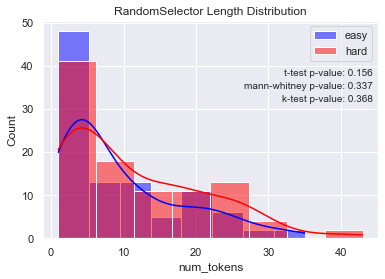

DiversitySelector


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

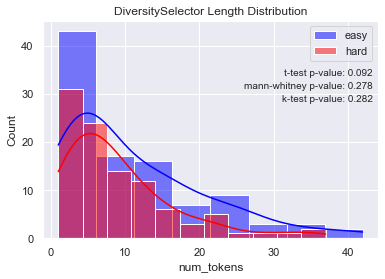

ClusterSelector


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

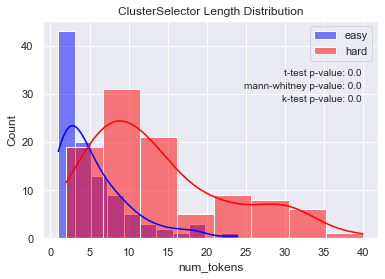

In [22]:
num_samples = 100
for selector in selectors:
    
    selector_name = selector.__class__.__name__
    
    print(selector_name)
    
    if selector_name == "RandomSelector":
        easy_dataset = selector.random_subset(num_samples, seed=0)
        hard_dataset = selector.random_subset(num_samples, seed=1)
    else:
        easy_dataset = selector.easy_subset(num_samples)
        hard_dataset = selector.hard_subset(num_samples)
    
    easy_dataset = easy_dataset.map(apply_word_tokenizer, batched=True, batch_size=100)
    hard_dataset = hard_dataset.map(apply_word_tokenizer, batched=True, batch_size=100)
    
    plot_and_compare_distribution(easy_dataset, hard_dataset, title=selector_name + " Length Distribution")